<a href="https://colab.research.google.com/github/Shrey-Viradiya/HandsOnMachineLearning/blob/master/Representation_Learning_and_Generative_Learning_Using_Autoencoders_and_GANs.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning and Generative Learning Using Autoencoders and GANs

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

## Performing PCA with an Undercomplete Linear Autoencoder

In [5]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape = [3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape = [2]))
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss = 'mse', optimizer=keras.optimizers.SGD(lr=1.5))

### Generate 3D data for training

In [6]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

In [7]:
X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [8]:
history = autoencoder.fit(X_train, X_train, epochs = 20)
coding = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.2998
Epoch 2/20
2/2 [==============================] - 0s 1ms/step - loss: 0.2108
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1446
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1195
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0847
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0735
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0663
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0576
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0450
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0441
Epoch 11/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0414
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0412
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0

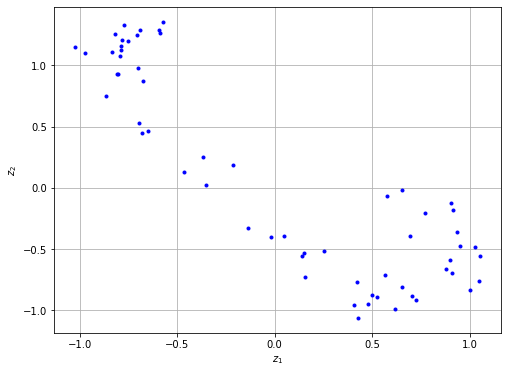

In [9]:
fig = plt.figure(figsize=(8,6))
plt.plot(coding[:,0], coding[:, 1], "b.")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.grid(True)
plt.show()

## Stacked Autoencoders

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(100, activation = 'selu'),
    keras.layers.Dense(30, activation = 'selu')
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])    
])

stacked_AE = keras.models.Sequential([stacked_encoder, stacked_decoder])

'''
When compiling the stacked autoencoder, we use the binary cross-entropy 
loss instead of the mean squared error. We are treating the 
reconstruction task as a multilabel binary classification problem: 
each pixel intensity represents the probability that the pixel 
should be black. Framing it this way (rather than as a regression 
problem) tends to make the model converge faster.
'''
stacked_AE.compile(loss='binary_crossentropy', optimizer= keras.optimizers.SGD(lr = 1.5),
                  metrics = [rounded_accuracy])

In [14]:
history = stacked_AE.fit(X_train, X_train, epochs= 20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9003
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2986 - rounded_accuracy: 0.9216 - val_loss: 0.2984 - val_rounded_accuracy: 0.9201
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9285
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

In [15]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [16]:
def show_reconstructions(AE,images=X_valid, n_images=5):
    reconstructions = AE.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 4.5))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

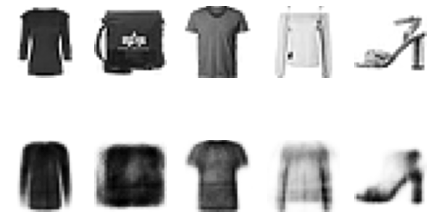

In [17]:
show_reconstructions(stacked_AE)

## Visualizing Fashion MNIST

Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms, but one big advantage of autoencoders is that they can handle large datasets, with many instances and many features. So one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization. Let’s use this strategy to visualize Fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use Scikit-Learn’s implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization

In [18]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

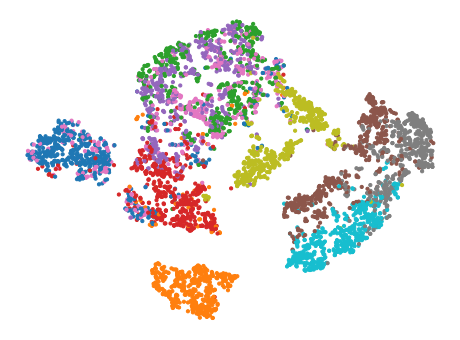

In [19]:
plt.figure(figsize = (8,6))
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:,1], c=y_valid, s=10, cmap='tab10')
plt.axis(False)
plt.show()

# Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.


Specifically, if the autoencoder has a total of N layers (not counting the input layer), and $W_L$ represents the connection weights of the $L^{th}$ layer (e.g., layer 1 is the first hidden layer, layer N/2 is the coding layer, and layer N is the output layer), then the decoder layer weights can be defined simply as: $W_{N–L+1} = W_{L^T}$ (with L = 1, 2, …, N/2).

In [20]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name = 'bias',
                                      shape = [self.dense.input_shape[-1]],
                                      initializer = 'zeros')
        super().build(batch_input_shape)
        
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation = 'selu')
dense_2 = keras.layers.Dense(30, activation = 'selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_AE= keras.models.Sequential([tied_encoder, tied_decoder])
tied_AE.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5), 
               metrics = [rounded_accuracy])

In [22]:
history = tied_AE.fit(X_train, X_train, epochs =10,
                     validation_data = (X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9077
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3017 - val_rounded_accuracy: 0.9087
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9332
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2874 - val_rounded_accuracy: 0.9313
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2860 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

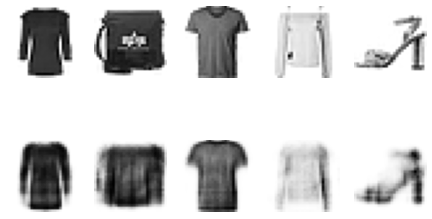

In [23]:
show_reconstructions(tied_AE)

## Training one Autoencoder at a Time

In [24]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                     n_epochs = 10, output_activation = None, metrics = None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation = 'selu', input_shape = [n_inputs]),        
    ])
    
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation = output_activation)        
    ])
    
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics = metrics)
    autoencoder.fit(X_train, X_train, epochs = n_epochs,
                   validation_data = (X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_flat = keras.backend.batch_flatten(X_train)
X_valid_flat = keras.backend.batch_flatten(X_valid)

enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(100, X_train_flat, X_valid_flat,
                                                          'binary_crossentropy',
                                                          keras.optimizers.SGD(lr=1.5),
                                                          output_activation='sigmoid',
                                                          metrics = [rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(30, X_train_enc1, X_valid_enc1, 'mse',
                                    keras.optimizers.SGD(lr=0.05),
                                    output_activation = 'selu')

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [26]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

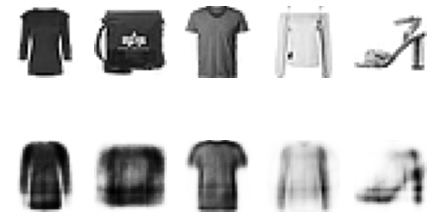

In [27]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [28]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9351
Epoch 7/10
1719/1719 [==================

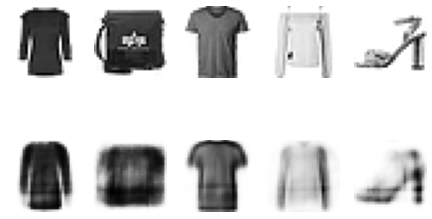

In [29]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Convolutional Autoencoders

In [30]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size = 3, padding='same', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid',
                                activation='selu',
                                input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
                                activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                                activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

conv_AE = keras.models.Sequential([conv_encoder, conv_decoder])

In [31]:
conv_AE.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_AE.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.3013 - rounded_accuracy: 0.9192 - val_loss: 0.2841 - val_rounded_accuracy: 0.9315
Epoch 2/5
1719/1719 [==============================] - 20s 11ms/step - loss: 0.2750 - rounded_accuracy: 0.9419 - val_loss: 0.2741 - val_rounded_accuracy: 0.9454
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.2704 - rounded_accuracy: 0.9466 - val_loss: 0.2718 - val_rounded_accuracy: 0.9437
Epoch 4/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2680 - rounded_accuracy: 0.9491 - val_loss: 0.2680 - val_rounded_accuracy: 0.9504
Epoch 5/5
1719/1719 [==============================] - 20s 12ms/step - loss: 0.2663 - rounded_accuracy: 0.9509 - val_loss: 0.2664 - val_rounded_accuracy: 0.9521


## Recurrent Autoencoders

In [32]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

In [33]:
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [34]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.5146 - rounded_accuracy: 0.7513 - val_loss: 0.4441 - val_rounded_accuracy: 0.8258
Epoch 2/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3991 - rounded_accuracy: 0.8462 - val_loss: 0.3748 - val_rounded_accuracy: 0.8621
Epoch 3/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3654 - rounded_accuracy: 0.8700 - val_loss: 0.3606 - val_rounded_accuracy: 0.8730
Epoch 4/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3528 - rounded_accuracy: 0.8797 - val_loss: 0.3527 - val_rounded_accuracy: 0.8795
Epoch 5/10
1719/1719 [==============================] - 34s 20ms/step - loss: 0.3425 - rounded_accuracy: 0.8872 - val_loss: 0.3399 - val_rounded_accuracy: 0.8891
Epoch 6/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3345 - rounded_accuracy: 0.8919 - val_loss: 0.3312 - val_rounded_accuracy: 0.8961
Epoch 7/10
1719/1719 [======

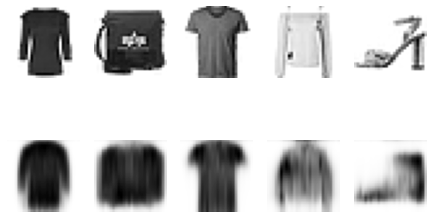

In [35]:
show_reconstructions(recurrent_ae)
plt.show()

## Denoising Autoencoders

In [36]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation = 'selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation = 'sigmoid'),
    keras.layers.Reshape([28, 28])
])

In [37]:
dropout_AE = keras.models.Sequential([
    dropout_encoder, dropout_decoder
])

In [44]:
dropout_AE.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.SGD(lr = 1.0), metrics=[rounded_accuracy])
history = dropout_AE.fit(X_train, X_train, epochs = 10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3002 - rounded_accuracy: 0.9175 - val_loss: 0.2962 - val_rounded_accuracy: 0.9243
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2996 - rounded_accuracy: 0.9180 - val_loss: 0.2959 - val_rounded_accuracy: 0.9244
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2989 - rounded_accuracy: 0.9185 - val_loss: 0.2949 - val_rounded_accuracy: 0.9243
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2984 - rounded_accuracy: 0.9189 - val_loss: 0.2948 - val_rounded_accuracy: 0.9255
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2979 - rounded_accuracy: 0.9193 - val_loss: 0.2940 - val_rounded_accuracy: 0.9258
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2974 - rounded_accuracy: 0.9197 - val_loss: 0.2947 - val_rounded_accuracy: 0.9227
Epoch 7/10
1719/1719 [==================

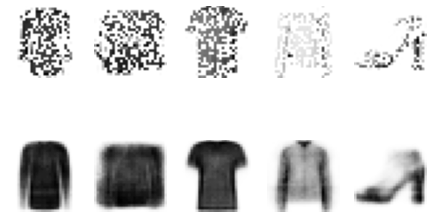

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.Dropout(0.5)
show_reconstructions(dropout_AE, noise(X_valid, training=True))
plt.show()

In [46]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [47]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3499 - rounded_accuracy: 0.8774 - val_loss: 0.3174 - val_rounded_accuracy: 0.9052
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3122 - rounded_accuracy: 0.9095 - val_loss: 0.3086 - val_rounded_accuracy: 0.9121
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3063 - rounded_accuracy: 0.9146 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3028 - rounded_accuracy: 0.9177 - val_loss: 0.3002 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2976 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9265
Epoch 7/10
1719/1719 [==================

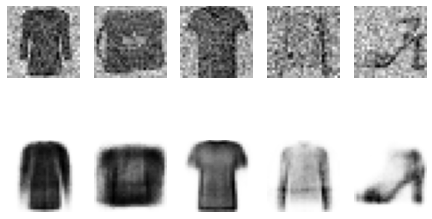

In [48]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()